<a href="https://colab.research.google.com/github/anubhavgupta1/Udacity/blob/main/Frameworks/Pytorch/DNNs/Cuda%20Support/Blob%20Data/BlobData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns
import time
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

import torch

In [2]:
torch.manual_seed(0)

In [3]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

## Generate Dataset

In [4]:
data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


## Plot the Data

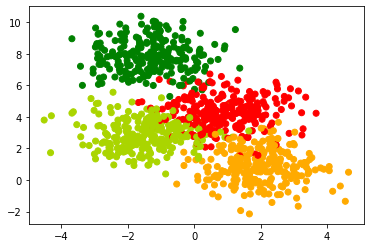

In [5]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

## Train Test Split

In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)
print(X_train.shape, X_val.shape, labels.shape)

(750, 2) (250, 2) (1000,)


## Using torch tensors and autograd

In [7]:
X_train, Y_train, X_val, Y_val = map(torch.tensor, (X_train, Y_train, X_val, Y_val))

In [8]:
print(X_train.shape, Y_train.shape)

torch.Size([750, 2]) torch.Size([750])


## GPU Configure

In [9]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
gpu = torch.device('cuda:0')


1
Tesla T4


In [10]:
X_train, Y_train, X_val, Y_val = X_train.float(), Y_train.long(), X_val.float(), Y_val.long()

In [11]:
X_train, Y_train, X_val, Y_val = X_train.to(gpu), Y_train.to(gpu), X_val.to(gpu), Y_val.to(gpu)

## Model Class

In [12]:
import torch.nn.functional as F
import torch.nn as nn
from torch import optim

In [17]:
class BlobData(nn.Module):
  
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.net = nn.Sequential(
        nn.Linear(2, 2), 
        nn.Sigmoid(), 
        nn.Linear(2, 4), 
        nn.Softmax()
    )

  def predict(self, X):
    return self.net(X)
  
  def accuracy(self, y_hat, y):
    pred_labels = torch.argmax(y_hat, dim=1)
    pred_binary = (pred_labels == y).float()
    average_acc = pred_binary.mean()
    return  average_acc

  def fit(self,X,Y,epochs = 1000, learning_rate = 1):
    loss_arr = []
    acc_arr  = []
    opt = optim.SGD(self.parameters(), lr=learning_rate)
    for epoch in range(epochs):
      Y_hat = self.predict(X)
      
      loss =  F.cross_entropy(Y_hat, Y)
      loss.backward()
      loss_arr.append(loss.item())
      
      acc = self.accuracy(Y_hat, Y)
      acc_arr.append(acc.item())
      
      opt.step()
      opt.zero_grad()

    plt.plot(loss_arr, 'r-')
    plt.plot(acc_arr, 'b-')
    plt.show()
    
    print('Loss before training', loss_arr[0])
    print('Loss after training', loss_arr[-1])
    return loss_arr, acc_arr

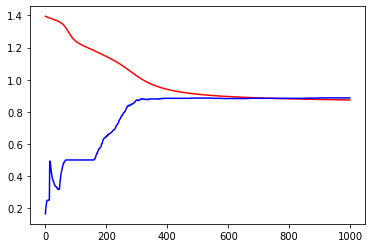

Loss before training 1.395159363746643
Loss after training 0.8738411664962769
CPU times: user 1.09 s, sys: 30.6 ms, total: 1.12 s
Wall time: 1.14 s


In [18]:
%%time
model = BlobData()
model = model.to(gpu)
loss, acc = model.fit(X_train,Y_train)

In [19]:
Y_pred = model.predict(X_val)
test_acc = model.accuracy(Y_pred,Y_val)

In [20]:
print("Training accuracy is : ", acc[-1])
print("Test accuracy is : ", test_acc.item())

Training accuracy is :  0.8866666555404663
Test accuracy is :  0.8880000710487366
